# Plan and solve agent

We'll begin with the planner functionality, and define the data structure and the corresponding instructions:

In [1]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_vertexai import ChatVertexAI


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: list[str] = Field(
        description="different steps to follow, should be in sorted order"
    )


system_prompt_template = (
    "For the given task, come up with a step by step plan.\n"
    "This plan should involve individual tasks, that if executed correctly will "
    "yield the correct answer. Do not add any superfluous steps.\n"
    "The result of the final step should be the final answer. Make sure that each "
    "step has all the information needed - do not skip steps."
)
planner_prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt_template),
     ("user", "Prepare a plan how to solve the following task:\n{task}\n")])

planner = planner_prompt | ChatVertexAI(
    model_name="gemini-1.5-pro-002", temperature=1.0
).with_structured_output(Plan)

We will re-use tools we built in previous sections:

In [2]:
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableLambda, RunnableConfig
from langchain_core.tools import tool, convert_runnable_to_tool


class CalculatorArgs(BaseModel):
    expression: str = Field(description="Mathematical expression to be evaluated")

def calculator(state: CalculatorArgs, config: RunnableConfig) -> str:
    expression = state["expression"]
    math_constants = config["configurable"].get("math_constants", {})
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


calculator_with_retry = RunnableLambda(calculator).with_retry(
    wait_exponential_jitter=True,
    stop_after_attempt=3,
)

calculator_tool = convert_runnable_to_tool(
    calculator_with_retry,
    name="calculator",
    description=(
        "Calculates a single mathematical expression, incl. complex numbers."
        "'\nAlways add * to operations, examples:\n73i -> 73*i\n"
        "7pi**2 -> 7*pi**2"
    ),
    args_schema=CalculatorArgs,
    arg_types={"expression": "str"},
)

In [3]:
from langchain.agents import load_tools

llm = ChatVertexAI(model="gemini-1.5-pro-002")
tools = load_tools(
  tool_names=["ddg-search", "arxiv", "wikipedia"],
  llm=llm
)

We will use these tools with a ReACT agent:

In [5]:
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState


system_prompt = (
    "You're a smart assistant that carefully helps to solve complex tasks.\n"
    " Given a general plan to solve a task and a specific step, work on this step. "
    " Don't assume anything, keep in minds things might change and always try to "
    "use tools to double-check yourself.\m"
    " Use a calculator for mathematical computations, use Search to gather"
    "for information about common facts, fresh events and news, use Arxiv to get "
    "ideas on recent research and use Wikipedia for common knowledge."
)

step_template = (
    "Given the task and the plan, try to execute on a specific step of the plan.\n"
    "TASK:\n{task}\n\nPLAN:\n{plan}\n\nSTEP TO EXECUTE:\n{step}\n"
)

prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", step_template),
])

class StepState(AgentState):
  plan: str
  step: str
  task: str

execution_agent = create_react_agent(model=llm, tools=tools+[calculator_tool], state_schema=StepState, prompt=prompt_template)

Now it's time to define our agent's state:

In [6]:
from typing import Annotated, TypedDict
import operator


task = "Write a strategic one-pager of building an AI startup?"

In [7]:
class PlanState(TypedDict):
    task: str
    plan: Plan
    past_steps: Annotated[list[str], operator.add]
    final_response: str


def get_current_step(state: PlanState) -> int:
  """Returns the number of current step to be executed."""
  return len(state.get("past_steps", []))

def get_full_plan(state: PlanState) -> str:
  """Returns formatted plan with step numbers and past results."""
  full_plan = []
  for i, step in enumerate(state["plan"].steps):
    full_step = f"# {i+1}. Planned step: {step}\n"
    if i < get_current_step(state):
      full_step += f"Result: {state['past_steps'][i]}\n"
    full_plan.append(full_step)
  return "\n".join(full_plan)

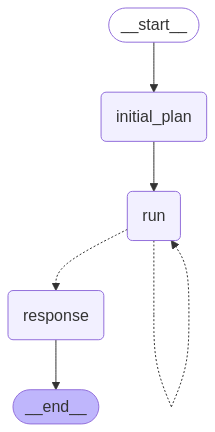

In [8]:
from typing import Literal
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END


final_prompt = PromptTemplate.from_template(
    "You're a helpful assistant that has executed on a plan."
    "Given the results of the execution, prepare the final response.\n"
    "Don't assume anything\nTASK:\n{task}\n\nPLAN WITH RESUlTS:\n{plan}\n"
    "FINAL RESPONSE:\n"
)

async def _build_initial_plan(state: PlanState) -> PlanState:
  plan = await planner.ainvoke(state["task"])
  return {"plan": plan}

async def _run_step(state: PlanState) -> PlanState:
  plan = state["plan"]
  current_step = get_current_step(state)
  step = await execution_agent.ainvoke({"plan": get_full_plan(state), "step": plan.steps[current_step], "task": state["task"]})
  return {"past_steps": [step["messages"][-1].content]}

async def _get_final_response(state: PlanState) -> PlanState:
  final_response = await (final_prompt | llm).ainvoke({"task": state["task"], "plan": get_full_plan(state)})
  return {"final_response": final_response}


def _should_continue(state: PlanState) -> Literal["run", "response"]:
  if get_current_step(state) < len(state["plan"].steps):
    return "run"
  return "response"

builder = StateGraph(PlanState)
builder.add_node("initial_plan", _build_initial_plan)
builder.add_node("run", _run_step)
builder.add_node("response", _get_final_response)

builder.add_edge(START, "initial_plan")
builder.add_edge("initial_plan", "run")
builder.add_conditional_edges("run", _should_continue)
builder.add_edge("response", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Now it's time to run it!

In [9]:
task = "Write a strategic one-pager of building an AI startup"
result = await graph.ainvoke({"task": task})

In [13]:
print(result["final_response"].content)

## Strategic One-Pager: AI Startup for Accurate Content Generation

**Problem:** Current language models hallucinate and contradict, undermining trust in AI-generated content for critical applications like research, journalism, and legal work.

**Solution:** An AI-powered language model with real-time fact-checking and knowledge grounding, ensuring accuracy and consistency.

**Target Audience:** Researchers, journalists, legal professionals, content creators, and organizations needing reliable information.

**Value Proposition:** Increased trust, improved decision-making, reduced misinformation, and enhanced productivity through accurate AI-generated content.

**Market Analysis:**

* **Competition:** Existing LLMs (GPT-3, Bard) lack robust fact-checking. Fact-checking tools exist but aren't seamlessly integrated. Niche AI writing tools address specific needs but not comprehensive accuracy.
* **Market Size:** The market for AI language models is substantial and growing rapidly (further 

We can also explore detailed steps:

In [14]:
async for output in graph.astream({"task": task}, stream_mode="updates"):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'initial_plan':
---
{'plan': Plan(steps=['1. Define the problem and solution: Clearly articulate the problem your AI startup aims to solve and how your AI-powered solution addresses it. Be specific about the target market and the value proposition.', '2. Technology and IP: Describe your core AI technology, including algorithms, datasets, and any intellectual property (IP) you possess. Highlight its unique advantages and defensibility.', '3. Business model: Outline your revenue generation strategy, pricing model, and target customer segments. Explain how your AI solution creates value for customers and how you will capture that value.', "4. Team and expertise: Showcase your team's expertise in AI, business development, and other relevant areas. Emphasize the experience and skills that make your team capable of executing the plan.", '5. Market analysis: Analyze the target market size, competition, and potential barriers to entry. Provide data-driven insights to support y